# Ridge regression
**Important**: Change the kernel to *PROJECT_NAME local*. You can do this from the *Kernel* menu under *Change kernel*.

In [28]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
import pickle
import os
import scipy.stats as st

In [2]:
model_name = "ridge"
aml_dir = os.environ['AZUREML_NATIVE_SHARE_DIRECTORY']
train = pd.read_csv(os.path.join(aml_dir, 'nyc_demand_train.csv'), parse_dates=['timeStamp'])

Create model pipeline:
- **one-hot encode categorical variables**
- **randomized parameter search** with cross validation to find optimal values for the alpha parameter

Fitting this pipeline should take less than a minute.

In [3]:
X = train.drop(['demand', 'timeStamp'], axis=1)

In [4]:
cat_cols = ['hour', 'month', 'dayofweek']
cat_cols_idx = [X.columns.get_loc(c) for c in X.columns if c in cat_cols]
onehot = OneHotEncoder(categorical_features=cat_cols_idx, sparse=False)
regr = Ridge(fit_intercept=False)
tscv = TimeSeriesSplit(n_splits=3)

In [44]:
param_dist = {'alpha': st.uniform(1e-4, 10.0)}
regr_cv = RandomizedSearchCV(estimator=regr,
                            param_distributions=param_dist,
                            n_iter=100,
                            scoring='neg_mean_squared_error',
                            iid=False,
                            cv=tscv,
                            verbose=2,
                            n_jobs=-1)
regr_pipe = Pipeline([('onehot', onehot), ('regr_cv', regr_cv)])
regr_pipe.fit(X, y=train['demand'])

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   19.6s finished


Pipeline(memory=None,
     steps=[('onehot', OneHotEncoder(categorical_features=[2, 3, 4], dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=False)), ('regr_cv', RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
          error_score='raise',
          estimator=Ridge(...it=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=2))])

In [ ]:
with open(os.path.join(aml_dir, model_name + '.pkl'), 'wb') as f:
    pickle.dump(regr_pipe, f)

Cross validation results

In [49]:
cv_results = pd.DataFrame(regr_pipe.named_steps['regr_cv'].cv_results_)
cv_results.sort_values(by='rank_test_score').head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
90,0.112170,0.005502,-3869.631983,-4220.100380,6.38998,{'alpha': 6.38997841215},1,-4166.876339,-4383.117349,-3678.428065,-4236.928000,-3763.591547,-4040.255792,0.027600,0.002830,213.039683,140.477491
89,0.117835,0.005834,-3869.631995,-4220.042027,6.3477,{'alpha': 6.34769564653},2,-4166.809683,-4382.996255,-3678.453349,-4236.891672,-3763.632953,-4040.238155,0.028696,0.003323,212.994249,140.436727
73,0.129833,0.005339,-3869.632009,-4220.037259,6.34423,{'alpha': 6.34423324423},3,-4166.804250,-4382.986357,-3678.455428,-4236.888704,-3763.636350,-4040.236714,0.035988,0.000622,212.990536,140.433395
97,0.130001,0.006502,-3869.632051,-4220.026280,6.33626,{'alpha': 6.33625824675},4,-4166.791750,-4382.963569,-3678.460224,-4236.881873,-3763.644179,-4040.233399,0.027558,0.004263,212.981989,140.425723
82,0.115335,0.006335,-3869.632790,-4220.210587,6.46941,{'alpha': 6.46940516762},5,-4167.003070,-4383.345924,-3678.381125,-4236.996679,-3763.514175,-4040.289159,0.029196,0.001845,213.125506,140.554416


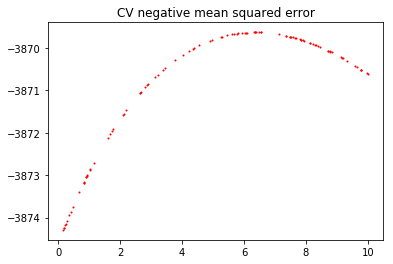

In [48]:
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'], 'ro', markersize=1)
plt.title('CV negative mean squared error')
plt.show()